# Étape 1 : Initialisation et Téléchargement des Données

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Téléchargement des données avec yfinance
donnees_brutes = yf.download('AAPL', start='2020-01-01', end='2024-10-25')

# Fonction pour nettoyer et prétraiter les données
def clean_and_preprocess(data):
    # Renommer les colonnes
    data = data.rename(columns={
        'Adj Close': 'Prix Ajusté',
        'Open': 'Ouverture',
        'High': 'Haut',
        'Low': 'Bas',
        'Close': 'Cloture',
        'Volume': 'Volume'
    })
    # Garde uniquement les colonnes nécessaires pour le calcul des rendements
    data = data[['Prix Ajusté']].copy()
    # Calcul des rendements quotidiens
    data['Rendement Quotidien'] = data['Prix Ajusté'].pct_change()
    # Calcul du rendement cumulé
    data['Rendement Cumulé'] = (1 + data['Rendement Quotidien']).cumprod()
    # Supprime les lignes contenant des valeurs NaN
    data.dropna(inplace=True)
    return data

# Application de la méthode de nettoyage
donnees = clean_and_preprocess(donnees_brutes)

# Afficher les résultats après traitement
print(donnees.head())


[*********************100%***********************]  1 of 1 completed

Price                     Prix Ajusté Rendement Quotidien Rendement Cumulé
Ticker                           AAPL                                     
Date                                                                      
2020-01-03 00:00:00+00:00   72.088287           -0.009722         0.990278
2020-01-06 00:00:00+00:00   72.662704            0.007968         0.998169
2020-01-07 00:00:00+00:00   72.320961           -0.004703         0.993474
2020-01-08 00:00:00+00:00   73.484352            0.016086         1.009456
2020-01-09 00:00:00+00:00   75.045227            0.021241         1.030897


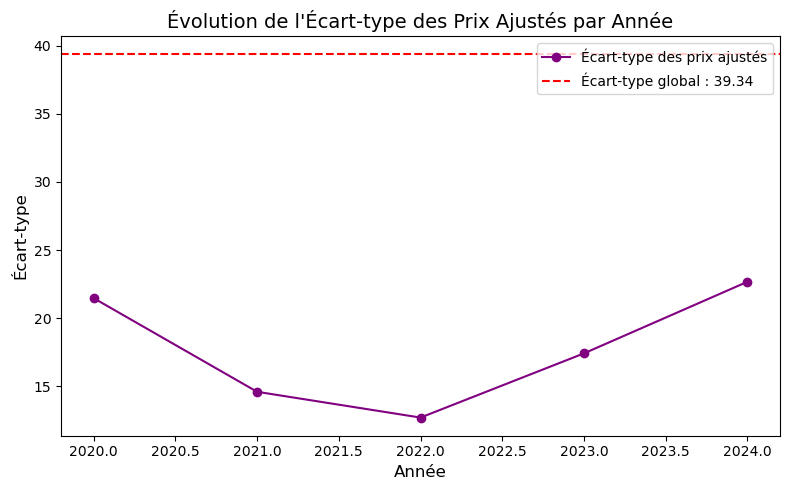

In [11]:
# Calcul des écarts-types par année
donnees['Année'] = donnees.index.year
ecarts_type_annuels = donnees.groupby('Année')['Prix Ajusté'].std()

# Écart-type global
ecart_type_global = donnees['Prix Ajusté'].std()

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(ecarts_type_annuels.index, ecarts_type_annuels, marker='o', color='purple', label="Écart-type des prix ajustés")
plt.axhline(y=ecart_type_global, color='red', linestyle='--', label=f"Écart-type global : {ecart_type_global:.2f}")
plt.title("Évolution de l'Écart-type des Prix Ajustés par Année", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Écart-type", fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()


## Étape 2 : Simulation d’Investissement Passif avec Contributions Récurrentes

In [5]:
# Définition de la contribution mensuelle
contribution_mensuelle = 500  # Montant des contributions mensuelles en euros

# Vérification si l'index est déjà au courant du fuseau horaire
if donnees.index.tz is not None:
    donnees['Mois'] = donnees.index.tz_convert('UTC').to_period('M')  # Convertir en période en conservant le fuseau
else:
    donnees['Mois'] = donnees.index.to_period('M')  # Pas de fuseau horaire, convertir directement

# Correction : Utiliser iloc[-1] pour obtenir le dernier prix de clôture du mois
donnees_mensuelles = donnees.groupby('Mois').apply(lambda x: x['Prix Ajusté'].iloc[-1]).reset_index()

# Renommer les colonnes pour plus de clarté
donnees_mensuelles.columns = ['Mois', 'Prix']

# Vérification que donnees_mensuelles est une série
print("Donnees mensuelles (avant simulation):")
print(donnees_mensuelles)

# Simulation des contributions mensuelles avec intérêt composé
montant_initial = 0  # On définit le montal initial ici
valeur_portefeuille = montant_initial
valeurs_portefeuille = []

# Récupérer les pourcentages de changement de manière appropriée
changement_pct = donnees_mensuelles['Prix'].pct_change().fillna(0)

# Utiliser une boucle sur l'index de donnees_mensuelles pour accéder aux éléments
for i in range(len(donnees_mensuelles)):
    valeur_portefeuille += contribution_mensuelle
    # Accéder au changement_pct par l'index (mois) mais gérer l'index correctement
    if i > 0:  # On ne peut pas utiliser le premier mois car il n'a pas de changement
        valeur_portefeuille *= (1 + changement_pct.iloc[i - 1])  # Utiliser iloc pour obtenir la bonne valeur
    valeurs_portefeuille.append(valeur_portefeuille)

# Convertir la liste en série pour s'assurer qu'elle est 1D
valeurs_portefeuille = pd.Series(valeurs_portefeuille)

# Vérification des longueurs
print("Longueur de valeurs_portefeuille:", len(valeurs_portefeuille))
print("Longueur de donnees_mensuelles:", len(donnees_mensuelles))

# Ajouter les valeurs du portefeuille au DataFrame
try:
    donnees_mensuelles['Valeur du Portefeuille'] = valeurs_portefeuille
    print(donnees_mensuelles)
except ValueError as e:
    print("Erreur lors de la création du DataFrame:", e)




Donnees mensuelles (avant simulation):
       Mois        Prix
0   2020-01   75.016129
1   2020-02   66.411674
2   2020-03   61.778694
3   2020-04   71.377495
4   2020-05   77.451286
5   2020-06   88.866554
6   2020-07  103.541229
7   2020-08  125.965096
8   2020-09  113.050354
9   2020-10  106.265953
10  2020-11  116.413635
11  2020-12  129.751602
12  2021-01  129.037781
13  2021-02  118.751884
14  2021-03  119.623489
15  2021-04  128.740891
16  2021-05  122.239876
17  2021-06  134.354965
18  2021-07  143.085663
19  2021-08  149.165298
20  2021-09  139.016586
21  2021-10  147.170929
22  2021-11  162.635925
23  2021-12  174.708145
24  2022-01  171.963104
25  2022-02  162.665787
26  2022-03  172.014740
27  2022-04  155.306793
28  2022-05  146.843201
29  2022-06  134.885773
30  2022-07  160.329803
31  2022-08  155.326233
32  2022-09  136.535339
33  2022-10  151.492981
34  2022-11  146.489532
35  2022-12  128.577881
36  2023-01  142.788452
37  2023-02  146.098709
38  2023-03  163.433136
3

C:\Users\33767\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


# Étape 3 : Calcul du Ratio de Sharpe, de la Volatilité, CAGR et le Rendement total

[*********************100%***********************]  1 of 1 completed

Analyse des performances du portefeuille :
Volatilité du portefeuille : 32.13%
Ratio de Sharpe : 0.84
Rendement total : 216.39%
Taux de Croissance Annuel Composé (CAGR) : 27.05%


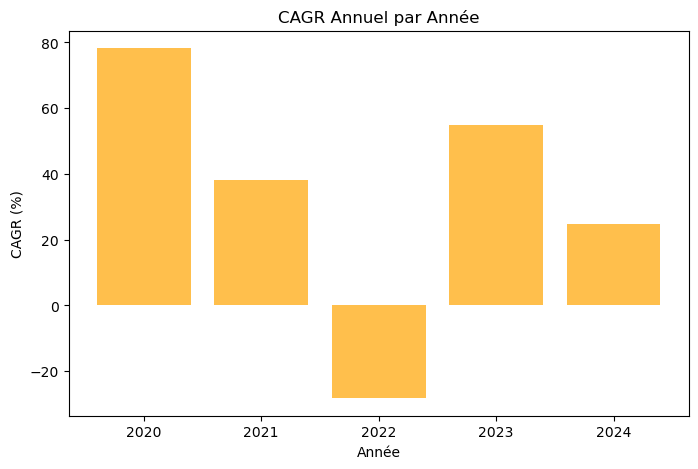

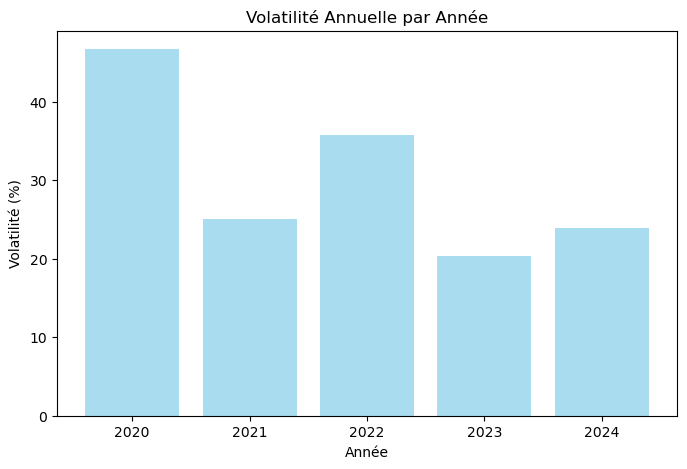

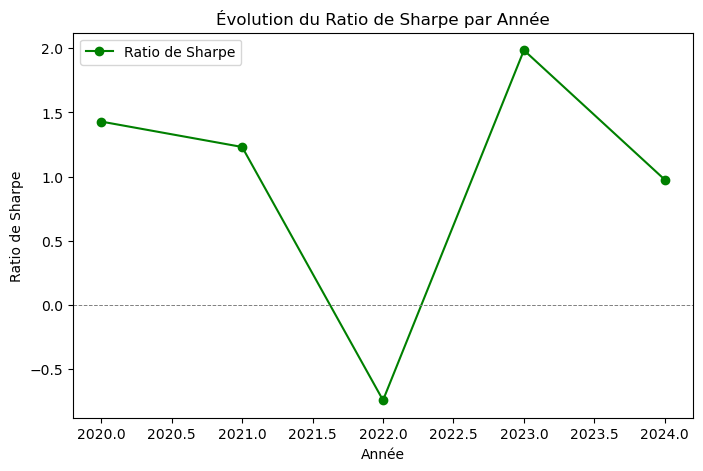

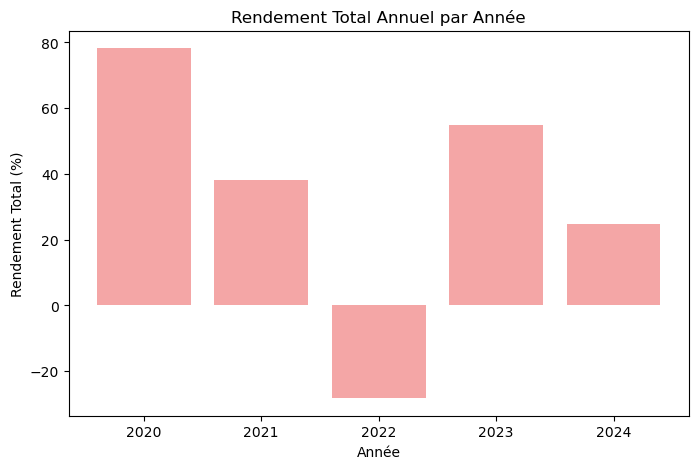

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Télécharger les données pour AAPL
donnees_brutes = yf.download('AAPL', start='2020-01-01', end='2024-10-25')
donnees = donnees_brutes[['Adj Close']].copy()
donnees.columns = ['Prix Ajusté']

# Calcul des rendements quotidiens
donnees['Rendement Quotidien'] = donnees['Prix Ajusté'].pct_change()

# Paramètre : taux de rendement sans risque (2 % annualisé)
taux_sans_risque = 0.02

# Calcul de la volatilité annualisée
volatilite_portefeuille = donnees['Rendement Quotidien'].std() * np.sqrt(252)

# Calcul du rendement annualisé du portefeuille
rendement_portefeuille = donnees['Rendement Quotidien'].mean() * 252

# Calcul du ratio de Sharpe
ratio_sharpe = (rendement_portefeuille - taux_sans_risque) / volatilite_portefeuille

# Calcul du rendement total
valeur_initiale = donnees['Prix Ajusté'].iloc[0]
valeur_finale = donnees['Prix Ajusté'].iloc[-1]
rendement_total = ((valeur_finale - valeur_initiale) / valeur_initiale) * 100

# Calcul du CAGR (Taux de Croissance Annuel Composé)
nombre_annees = (donnees.index[-1] - donnees.index[0]).days / 365.25
cagr = ((valeur_finale / valeur_initiale) ** (1 / nombre_annees) - 1) * 100

# Afficher les résultats
print("Analyse des performances du portefeuille :")
print(f"Volatilité du portefeuille : {volatilite_portefeuille:.2%}")
print(f"Ratio de Sharpe : {ratio_sharpe:.2f}")
print(f"Rendement total : {rendement_total:.2f}%")
print(f"Taux de Croissance Annuel Composé (CAGR) : {cagr:.2f}%")

# Calcul du CAGR annuel par année civile
donnees['Année'] = donnees.index.year  # Extraire l'année
cagr_par_annee = []

# Boucle pour chaque année
for annee in donnees['Année'].unique():
    donnees_annee = donnees[donnees['Année'] == annee]
    if len(donnees_annee) > 1:  # Vérifie qu'il y a des données suffisantes
        valeur_debut = donnees_annee['Prix Ajusté'].iloc[0]
        valeur_fin = donnees_annee['Prix Ajusté'].iloc[-1]
        cagr_annuel = ((valeur_fin / valeur_debut) - 1) * 100
        cagr_par_annee.append({'Année': annee, 'CAGR Annuel (%)': cagr_annuel})

# Créer un DataFrame pour le visualiser
cagr_par_annee_df = pd.DataFrame(cagr_par_annee)

# Visualiser l'évolution par année
plt.figure(figsize=(8, 5))
plt.bar(cagr_par_annee_df['Année'], cagr_par_annee_df['CAGR Annuel (%)'], color='orange', alpha=0.7)
plt.title("CAGR Annuel par Année")
plt.xlabel("Année")
plt.ylabel("CAGR (%)")
plt.show()

# Calcul de la volatilité annuelle par année
volatilite_annuelle = donnees.groupby('Année')['Rendement Quotidien'].std() * np.sqrt(252)

# Visualisation de la volatilité annuelle
plt.figure(figsize=(8, 5))
plt.bar(volatilite_annuelle.index, volatilite_annuelle * 100, color='skyblue', alpha=0.7)
plt.title("Volatilité Annuelle par Année")
plt.xlabel("Année")
plt.ylabel("Volatilité (%)")
plt.show()

# Calcul du rendement annuel moyen et volatilité annuelle pour Sharpe par année
rendement_annuel = donnees.groupby('Année')['Rendement Quotidien'].mean() * 252
ratio_sharpe_annuel = (rendement_annuel - taux_sans_risque) / (volatilite_annuelle)

# Visualisation du Ratio de Sharpe annuel
plt.figure(figsize=(8, 5))
plt.plot(ratio_sharpe_annuel.index, ratio_sharpe_annuel, marker='o', color='green', label="Ratio de Sharpe")
plt.title("Évolution du Ratio de Sharpe par Année")
plt.xlabel("Année")
plt.ylabel("Ratio de Sharpe")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)  # Ligne de référence
plt.legend()
plt.show()

# Calcul du rendement total par année
rendement_total_annuel = donnees.groupby('Année').apply(
    lambda x: ((x['Prix Ajusté'].iloc[-1] / x['Prix Ajusté'].iloc[0]) - 1) * 100
)

# Visualisation du rendement total annuel
plt.figure(figsize=(8, 5))
plt.bar(rendement_total_annuel.index, rendement_total_annuel, color='lightcoral', alpha=0.7)
plt.title("Rendement Total Annuel par Année")
plt.xlabel("Année")
plt.ylabel("Rendement Total (%)")
plt.show()




# Étape 4 : Visualisation de la Performance Cumulée, Histogramme des Rendements et la Volatilité des rendements (Boîte à Moustaches)

[*********************100%***********************]  1 of 1 completed
C:\Users\33767\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


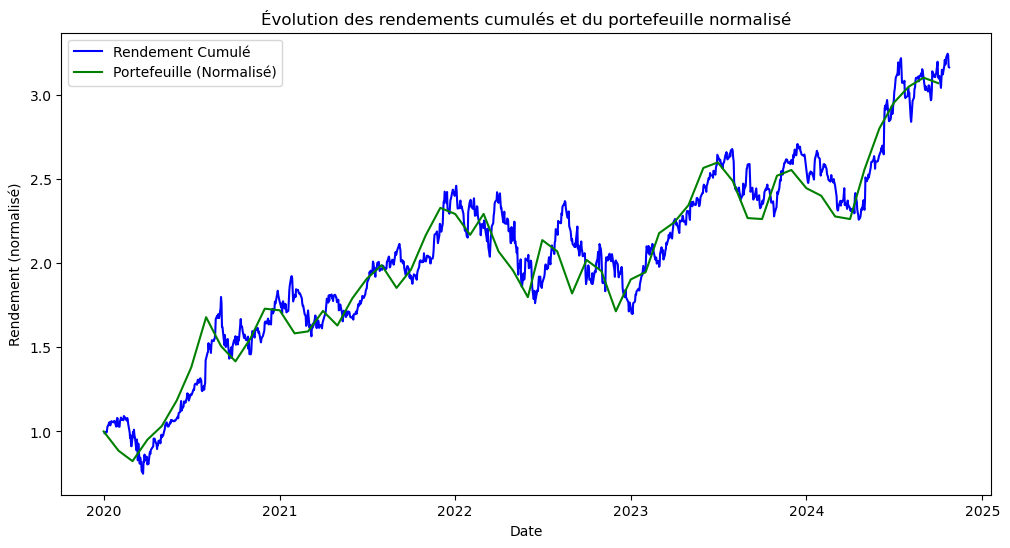

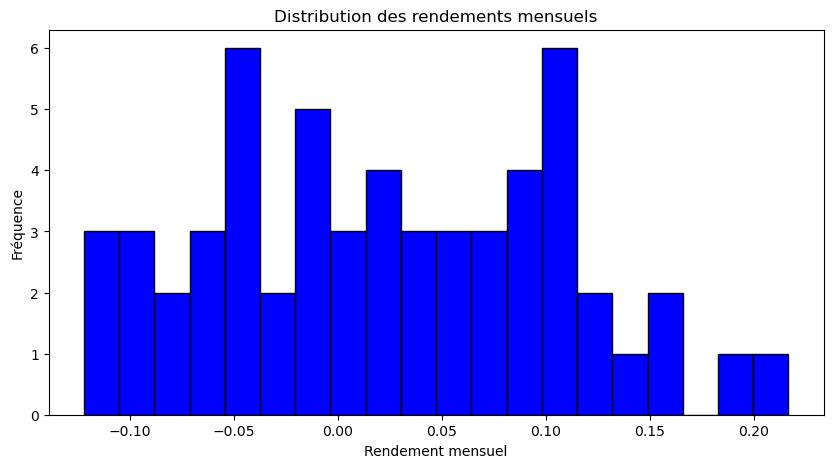

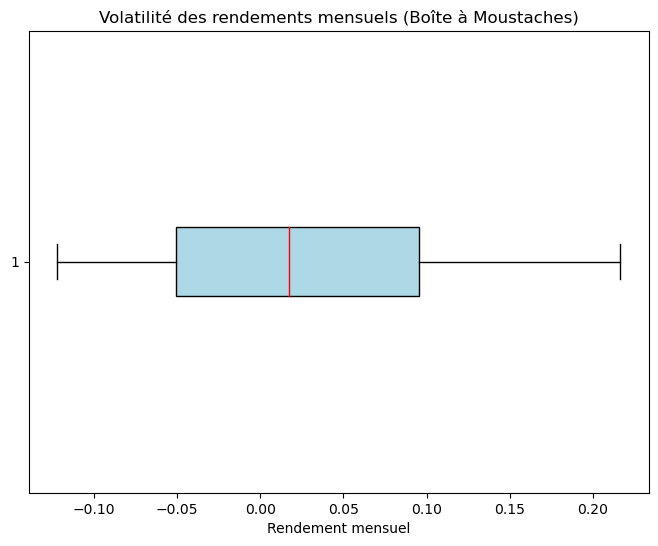

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Télécharger les données historiques pour AAPL
donnees_brutes = yf.download('AAPL', start='2020-01-01', end='2024-10-25')
donnees = donnees_brutes[['Adj Close']].copy()
donnees.columns = ['Prix Ajusté']

# Calcul des rendements quotidiens et cumulés
donnees['Rendement Quotidien'] = donnees['Prix Ajusté'].pct_change()
donnees['Rendement Cumulé'] = (1 + donnees['Rendement Quotidien']).cumprod()

# Regrouper les données par mois
donnees['Mois'] = donnees.index.to_period('M')
donnees_mensuelles = donnees.groupby('Mois').last()
donnees_mensuelles['Rendement Mensuel'] = donnees_mensuelles['Prix Ajusté'].pct_change()

# Convertir les périodes mensuelles en timestamps pour faciliter la visualisation
donnees_mensuelles['Date'] = donnees_mensuelles.index.to_timestamp()
donnees_mensuelles.set_index('Date', inplace=True)

# Normaliser le portefeuille pour une comparaison cohérente
normalized_portfolio = donnees_mensuelles['Prix Ajusté'] / donnees_mensuelles['Prix Ajusté'].iloc[0]

# Courbe de performance cumulée
plt.figure(figsize=(12, 6))
plt.plot(donnees.index, donnees['Rendement Cumulé'], label='Rendement Cumulé', color='blue')
plt.plot(donnees_mensuelles.index, normalized_portfolio, 
         label='Portefeuille (Normalisé)', color='green')
plt.xlabel('Date')
plt.ylabel('Rendement (normalisé)')
plt.legend()
plt.title("Évolution des rendements cumulés et du portefeuille normalisé")
plt.show()

# Histogramme des rendements mensuels
plt.figure(figsize=(10, 5))
plt.hist(donnees_mensuelles['Rendement Mensuel'].dropna(), bins=20, edgecolor='black', color='blue')
plt.title("Distribution des rendements mensuels")
plt.xlabel("Rendement mensuel")
plt.ylabel("Fréquence")
plt.show()

# Boîte à moustaches des rendements mensuels
plt.figure(figsize=(8, 6))
plt.boxplot(donnees_mensuelles['Rendement Mensuel'].dropna(), vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='red'))
plt.title("Volatilité des rendements mensuels (Boîte à Moustaches)")
plt.xlabel("Rendement mensuel")
plt.show()



# Étape 5 : Comparaison du portefeuille à l’indice mondial ACWI IMI 

[*********************100%***********************]  1 of 1 completed


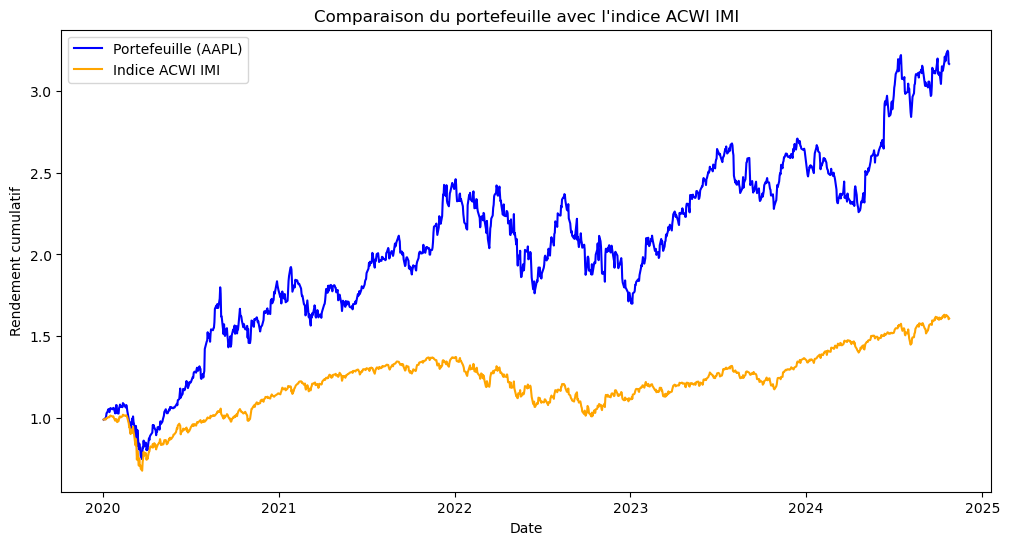

In [68]:
# Télécharger les données de l'ETF de référence (ACWI IMI)
donnees_acwi = yf.download('ACWI', start='2020-01-01', end='2024-10-25')
donnees_acwi['Rendement Cumulé'] = (1 + donnees_acwi['Adj Close'].pct_change()).cumprod()

# Graphique de comparaison de la performance
plt.figure(figsize=(12, 6))
plt.plot(donnees.index, donnees['Rendement Cumulé'], label='Portefeuille (AAPL)', color='blue')
plt.plot(donnees_acwi.index, donnees_acwi['Rendement Cumulé'], label='Indice ACWI IMI', color='orange')
plt.xlabel('Date')
plt.ylabel('Rendement cumulatif')
plt.legend()
plt.title("Comparaison du portefeuille avec l'indice ACWI IMI")
plt.show()


# Étape 6 : Comparaison des Stratégies d'Investissement : Lump Sum vs DCA

[*********************100%***********************]  1 of 1 completed


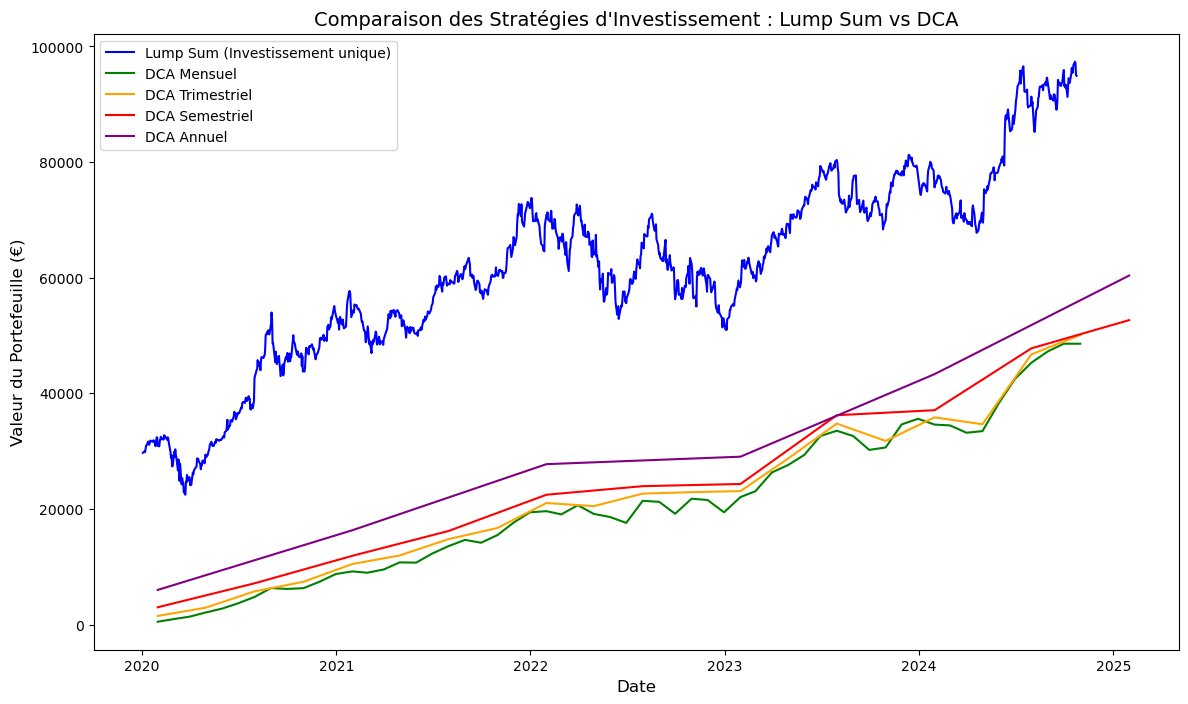

Valeur finale Lump Sum : 94915.8834231868
Valeur finale DCA Mensuel : 48575.46913286724
Valeur finale DCA Trimestriel : 50083.30849367456
Valeur finale DCA Semestriel : 52661.48044883917
Valeur finale DCA Annuel : 60375.35532300376


In [13]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Télécharger les données pour AAPL
donnees_brutes = yf.download('AAPL', start='2020-01-01', end='2024-10-25')

# On garde uniquement la colonne du prix ajusté
donnees = donnees_brutes[['Adj Close']].copy()
donnees.columns = ['Prix Ajusté']

# Calcul des rendements quotidiens et cumulatifs
donnees['Rendement Quotidien'] = donnees['Prix Ajusté'].pct_change()
donnees['Rendement Cumulé'] = (1 + donnees['Rendement Quotidien']).cumprod()

# Simulation de l’investissement Lump Sum
montant_initial = 30000  # Investissement initial en euros
donnees['Valeur Lump Sum'] = montant_initial * donnees['Rendement Cumulé']

# Simulation DCA (Contributions mensuelles, trimestrielles, semestrielles, annuelles)
contribution_mensuelle = 500
contributions_dca = {
    'Mensuel': contribution_mensuelle,
    'Trimestriel': contribution_mensuelle * 3,
    'Semestriel': contribution_mensuelle * 6,
    'Annuel': contribution_mensuelle * 12
}

# Fonction pour calculer la valeur du portefeuille DCA
def calcul_dca(prix_par_periode, contribution):
    valeur_actuelle = 0
    valeur_portefeuille = []
    for prix in prix_par_periode:
        valeur_actuelle += contribution / prix  # Acheter des actions
        valeur_portefeuille.append(valeur_actuelle * prix)  # Valeur actuelle
    return valeur_portefeuille

# Calcul des prix par période
prix_mensuels = donnees.resample('M').last()['Prix Ajusté']
prix_trimestriels = donnees.resample('3M').last()['Prix Ajusté']
prix_semestriels = donnees.resample('6M').last()['Prix Ajusté']
prix_annuels = donnees.resample('12M').last()['Prix Ajusté']

# Calcul des portefeuilles DCA
portefeuille_dca = {
    'Mensuel': calcul_dca(prix_mensuels, contributions_dca['Mensuel']),
    'Trimestriel': calcul_dca(prix_trimestriels, contributions_dca['Trimestriel']),
    'Semestriel': calcul_dca(prix_semestriels, contributions_dca['Semestriel']),
    'Annuel': calcul_dca(prix_annuels, contributions_dca['Annuel'])
}

# Créer des DataFrames pour chaque stratégie
dca_mensuel = pd.DataFrame({
    'Prix': prix_mensuels,
    'Valeur Portefeuille': portefeuille_dca['Mensuel']
}, index=prix_mensuels.index)

dca_trimestriel = pd.DataFrame({
    'Prix': prix_trimestriels,
    'Valeur Portefeuille': portefeuille_dca['Trimestriel']
}, index=prix_trimestriels.index)

dca_semestriel = pd.DataFrame({
    'Prix': prix_semestriels,
    'Valeur Portefeuille': portefeuille_dca['Semestriel']
}, index=prix_semestriels.index)

dca_annuel = pd.DataFrame({
    'Prix': prix_annuels,
    'Valeur Portefeuille': portefeuille_dca['Annuel']
}, index=prix_annuels.index)

# Visualisation des stratégies
plt.figure(figsize=(14, 8))
plt.plot(donnees.index, donnees['Valeur Lump Sum'], label='Lump Sum (Investissement unique)', color='blue')
plt.plot(dca_mensuel.index, dca_mensuel['Valeur Portefeuille'], label='DCA Mensuel', color='green')
plt.plot(dca_trimestriel.index, dca_trimestriel['Valeur Portefeuille'], label='DCA Trimestriel', color='orange')
plt.plot(dca_semestriel.index, dca_semestriel['Valeur Portefeuille'], label='DCA Semestriel', color='red')
plt.plot(dca_annuel.index, dca_annuel['Valeur Portefeuille'], label='DCA Annuel', color='purple')

# Légendes et titre
plt.title("Comparaison des Stratégies d'Investissement : Lump Sum vs DCA", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Valeur du Portefeuille (€)", fontsize=12)
plt.legend()
plt.show()

# Résultats finaux
print("Valeur finale Lump Sum :", donnees['Valeur Lump Sum'].iloc[-1])
print("Valeur finale DCA Mensuel :", dca_mensuel['Valeur Portefeuille'].iloc[-1])
print("Valeur finale DCA Trimestriel :", dca_trimestriel['Valeur Portefeuille'].iloc[-1])
print("Valeur finale DCA Semestriel :", dca_semestriel['Valeur Portefeuille'].iloc[-1])
print("Valeur finale DCA Annuel :", dca_annuel['Valeur Portefeuille'].iloc[-1])


# Étape 7 : Prédiction des rendements futurs avec régression linéaire et incertitudes

[*********************100%***********************]  1 of 1 completed


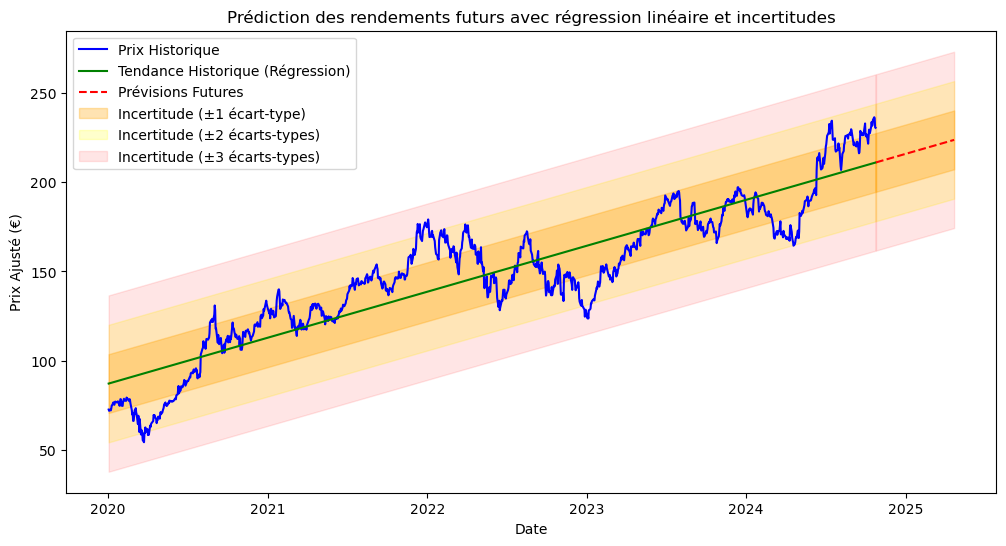

Prédictions futures (6 mois) avec incertitudes :
                           Prix Prévu  Limite Supérieure (±1)  \
Date                                                            
2024-10-25 00:00:00+00:00  210.975902              227.408528   
2024-10-26 00:00:00+00:00  211.046241              227.478866   
2024-10-27 00:00:00+00:00  211.116579              227.549205   
2024-10-28 00:00:00+00:00  211.186917              227.619543   
2024-10-29 00:00:00+00:00  211.257256              227.689882   
...                               ...                     ...   
2025-04-18 00:00:00+00:00  223.285132              239.717758   
2025-04-19 00:00:00+00:00  223.355470              239.788096   
2025-04-20 00:00:00+00:00  223.425809              239.858434   
2025-04-21 00:00:00+00:00  223.496147              239.928773   
2025-04-22 00:00:00+00:00  223.566486              239.999111   

                           Limite Inférieure (±1)  Limite Supérieure (±2)  \
Date                        

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Télécharger les données historiques
donnees_brutes = yf.download('AAPL', start='2020-01-01', end='2024-10-25')
donnees = donnees_brutes[['Adj Close']].copy()
donnees.columns = ['Prix Ajusté']

# Préparation des données pour la régression linéaire
donnees['Jours'] = (donnees.index - donnees.index[0]).days  # Convertir les dates en jours depuis le début
X = donnees['Jours'].values.reshape(-1, 1)  # Variable indépendante : jours
y = donnees['Prix Ajusté'].values.reshape(-1, 1)  # Variable dépendante : prix ajusté

# Créer et entraîner le modèle de régression linéaire
modele = LinearRegression()
modele.fit(X, y)

# Générer des prédictions sur les données existantes
donnees['Prix Prévu'] = modele.predict(X)

# Calcul des résidus et de l'écart type
donnees['Résidus'] = donnees['Prix Ajusté'] - donnees['Prix Prévu'].values
ecart_type_residus = donnees['Résidus'].std()

# Ajouter les bandes d'incertitude à l'historique
donnees['Limite Supérieure (±1)'] = donnees['Prix Prévu'] + ecart_type_residus
donnees['Limite Inférieure (±1)'] = donnees['Prix Prévu'] - ecart_type_residus
donnees['Limite Supérieure (±2)'] = donnees['Prix Prévu'] + 2 * ecart_type_residus
donnees['Limite Inférieure (±2)'] = donnees['Prix Prévu'] - 2 * ecart_type_residus
donnees['Limite Supérieure (±3)'] = donnees['Prix Prévu'] + 3 * ecart_type_residus
donnees['Limite Inférieure (±3)'] = donnees['Prix Prévu'] - 3 * ecart_type_residus

# Prévoir les rendements futurs sur 180 jours (6 mois)
jours_futurs = np.arange(donnees['Jours'].max() + 1, donnees['Jours'].max() + 181).reshape(-1, 1)
previsions_futures = modele.predict(jours_futurs)

# Ajouter les bandes d'incertitude pour les données futures
previsions_sup_1 = previsions_futures + ecart_type_residus
previsions_inf_1 = previsions_futures - ecart_type_residus
previsions_sup_2 = previsions_futures + 2 * ecart_type_residus
previsions_inf_2 = previsions_futures - 2 * ecart_type_residus
previsions_sup_3 = previsions_futures + 3 * ecart_type_residus
previsions_inf_3 = previsions_futures - 3 * ecart_type_residus

# Créer un DataFrame pour les données futures
dates_futures = pd.date_range(start=donnees.index[-1] + pd.Timedelta(days=1), periods=180, freq='D')
donnees_futures = pd.DataFrame({
    'Date': dates_futures,
    'Prix Prévu': previsions_futures.flatten(),
    'Limite Supérieure (±1)': previsions_sup_1.flatten(),
    'Limite Inférieure (±1)': previsions_inf_1.flatten(),
    'Limite Supérieure (±2)': previsions_sup_2.flatten(),
    'Limite Inférieure (±2)': previsions_inf_2.flatten(),
    'Limite Supérieure (±3)': previsions_sup_3.flatten(),
    'Limite Inférieure (±3)': previsions_inf_3.flatten()
})
donnees_futures.set_index('Date', inplace=True)

# Visualisation des données historiques, prévisions et bandes d'incertitude
plt.figure(figsize=(12, 6))
plt.plot(donnees.index, donnees['Prix Ajusté'], label='Prix Historique', color='blue')
plt.plot(donnees.index, donnees['Prix Prévu'], label='Tendance Historique (Régression)', color='green')
plt.plot(donnees_futures.index, donnees_futures['Prix Prévu'], label='Prévisions Futures', color='red', linestyle='--')

# Ajouter les bandes d'incertitude à l'historique
plt.fill_between(donnees.index, donnees['Limite Supérieure (±1)'], donnees['Limite Inférieure (±1)'], 
                 color='orange', alpha=0.3, label='Incertitude (±1 écart-type)')
plt.fill_between(donnees.index, donnees['Limite Supérieure (±2)'], donnees['Limite Inférieure (±2)'], 
                 color='yellow', alpha=0.2, label='Incertitude (±2 écarts-types)')
plt.fill_between(donnees.index, donnees['Limite Supérieure (±3)'], donnees['Limite Inférieure (±3)'], 
                 color='red', alpha=0.1, label='Incertitude (±3 écarts-types)')

# Ajouter les bandes d'incertitude aux prévisions futures
plt.fill_between(donnees_futures.index, 
                 donnees_futures['Limite Supérieure (±1)'], 
                 donnees_futures['Limite Inférieure (±1)'], 
                 color='orange', alpha=0.3)
plt.fill_between(donnees_futures.index, 
                 donnees_futures['Limite Supérieure (±2)'], 
                 donnees_futures['Limite Inférieure (±2)'], 
                 color='yellow', alpha=0.2)
plt.fill_between(donnees_futures.index, 
                 donnees_futures['Limite Supérieure (±3)'], 
                 donnees_futures['Limite Inférieure (±3)'], 
                 color='red', alpha=0.1)

plt.title("Prédiction des rendements futurs avec régression linéaire et incertitudes")
plt.xlabel("Date")
plt.ylabel("Prix Ajusté (€)")
plt.legend()
plt.show()

# Affichage des données prévues avec incertitudes
print("Prédictions futures (6 mois) avec incertitudes :")
print(donnees_futures)
